## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [1]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = spacy.load("en_core_web_sm", disable=['ner', 'parser'])
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint


/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [2]:
!pip install swifter
import swifter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 830.9/830.9 KB 9.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.2/280.2 KB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 49.8 MB/s eta 0:00:00
  Created wheel for swifter: filename=swifter-1.3.4-py3-none-any.whl size=16321 sha256=76e5fb069616ae7b8374fe3268a1f24453f8fd3962ccdb7f4f0d8d4ee1321506
  Stored in directory: /root/.cache/pip/wheels/08/66/b4/921e351e63d88696932279d6163e125727c9da70ed8ca38419
Successfully built swifter
  Attempting uninstall: psutil
    Found existing installation: psutil 5.4.8
    Uninstalling psutil-5.4.8:
      Successfully uninstalled psutil-5.4.8


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [5]:
# Importing libraries for text processing steps.
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [6]:
# Opening JSON file 
f = open("/content/drive/MyDrive/Colab Notebooks/NLP Case Study/complaints-2021-05-14_08_16.json")
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [7]:
# Inspect the dataframe to understand the given data.

df.head(10)

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A
5,complaint-public-v2,complaint,3275312,0.0,Older American,48227,3275312,Managing an account,2019-06-13T12:00:00-05:00,MI,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Referral,2019-06-14T12:00:00-05:00,None,Checking account,Yes,,Problem using a debit or ATM card,N/A
6,complaint-public-v2,complaint,3238804,0.0,None,76262,3238804,Managing an account,2019-05-10T12:00:00-05:00,TX,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Phone,2019-05-10T12:00:00-05:00,None,Checking account,Yes,,Problem using a debit or ATM card,N/A
7,complaint-public-v2,complaint,3249272,0.0,None,07753,3249272,Trouble during payment process,2019-05-15T12:00:00-05:00,NJ,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-05-21T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,N/A
8,complaint-public-v2,complaint,3351653,0.0,None,60621,3351653,Closing an account,2019-08-22T12:00:00-05:00,IL,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-08-23T12:00:00-05:00,None,Checking account,Yes,,Company closed your account,N/A
9,complaint-public-v2,complaint,3273612,0.0,None,99354,3273612,Managing an account,2019-06-11T12:00:00-05:00,WA,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Referral,2019-06-17T12:00:00-05:00,None,Checking account,Yes,,Cashing a check,N/A


In [8]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [9]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 2000)

In [10]:
#Assign new column names
df1=pd.DataFrame(df)

In [11]:
column_names=list(df.columns)

In [12]:
new_names=[columns.replace('_source.', '') for columns in column_names]
new_names

['_index',
 '_type',
 '_id',
 '_score',
 'tags',
 'zip_code',
 'complaint_id',
 'issue',
 'date_received',
 'state',
 'consumer_disputed',
 'product',
 'company_response',
 'company',
 'submitted_via',
 'date_sent_to_company',
 'company_public_response',
 'sub_product',
 'timely',
 'complaint_what_happened',
 'sub_issue',
 'consumer_consent_provided']

In [13]:
df1.columns=new_names
df1.head()

,_index,_type,_id,_score,tags,zip_code,complaint_id,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [14]:
#Assign nan in place of blanks in the complaints column
df2=df1[df1['complaint_what_happened'].astype(bool)]

In [15]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21072 entries, 1 to 78312
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   _index                     21072 non-null  object 
 1   _type                      21072 non-null  object 
 2   _id                        21072 non-null  object 
 3   _score                     21072 non-null  float64
 4   tags                       3816 non-null   object 
 5   zip_code                   16427 non-null  object 
 6   complaint_id               21072 non-null  object 
 7   issue                      21072 non-null  object 
 8   date_received              21072 non-null  object 
 9   state                      20929 non-null  object 
 10  consumer_disputed          21072 non-null  object 
 11  product                    21072 non-null  object 
 12  company_response           21072 non-null  object 
 13  company                    21072 non-null  obj

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [16]:
# Write your function here to clean the text and remove all the unnecessary elements.
def text_preprocess(text):
    text = text.lower() # text to lowercase
    text = re.sub(r'\s\{\$\S*', '',text) # Remove text within curly braces
    text = re.sub(r'\n', '', text) # Remove line breaks
    text = re.sub(r'\(\w*\)', '', text) #remove text within braces
    text = re.sub(r'(\W\s)|(\W$)|(\W\d*)', ' ',text) # Remove punctuation
    text = re.sub(r'x+((/xx)*/\d*\s*)|x*', '',text) #Remove date
    text = re.sub(r'\d+\s', '', text) #Remove other numerical values
    text = re.sub(r' +', ' ',text) #Remove unnecessary white spaces
    return text

In [17]:
df2['complaint_what_happened']

1        Good morning my name is XXXX XXXX and I apprec...
2        I upgraded my XXXX XXXX card in XX/XX/2018 and...
10       Chase Card was reported on XX/XX/2019. However...
11       On XX/XX/2018, while trying to book a XXXX  XX...
14       my grand son give me check for {$1600.00} i de...
                               ...                        
78303    After being a Chase Card customer for well ove...
78309    On Wednesday, XX/XX/XXXX I called Chas, my XXX...
78310    I am not familiar with XXXX pay and did not un...
78311    I have had flawless credit for 30 yrs. I've ha...
78312    Roughly 10+ years ago I closed out my accounts...
Name: complaint_what_happened, Length: 21072, dtype: object

In [18]:
df2['complaints_cleaned'] = df2.complaint_what_happened.apply(
    text_preprocess)
df2.head()

<ipython-input-18-bf4ab4042cb5>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,_index,_type,_id,_score,tags,zip_code,complaint_id,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided,complaints_cleaned
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided,good morning my name is and i appreciate it if...
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided,i upgraded my card in and was told by the agen...
10,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,N/A,"Credit reporting, credit repair services, or o...",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,Chase Card was reported on XX/XX/2019. However...,Information belongs to someone else,Consent provided,chase card was reported on however fraudulent ...
11,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,N/A,"Credit reporting, credit repair services, or o...",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,"On XX/XX/2018, while trying to book a XXXX XX...",Information belongs to someone else,Consent provided,on while trying to book a ticket i came across...
14,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,N/A,Checking or savings account,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for {$1600.00} i de...,Funds not handled or disbursed as instructed,Consent provided,my grand son give me check for i deposit it in...


In [19]:
#Write your function to Lemmatize the texts
def text_lemma(text):
    tokens = word_tokenize(text)
    wordnet_lemmetizer = WordNetLemmatizer()
    lemmatized = [wordnet_lemmetizer.lemmatize(token) for token in tokens]
    lemmatized_str = " ".join(lemmatized)
    return lemmatized_str

In [20]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean = pd.DataFrame({'complaints':df2['complaints_cleaned'], 'lemmatized':df2['complaints_cleaned'].apply(text_lemma)})

In [21]:
df_clean.head()

,complaints,lemmatized
1,good morning my name is and i appreciate it if...,good morning my name is and i appreciate it if...
2,i upgraded my card in and was told by the agen...,i upgraded my card in and wa told by the agent...
10,chase card was reported on however fraudulent ...,chase card wa reported on however fraudulent a...
11,on while trying to book a ticket i came across...,on while trying to book a ticket i came across...
14,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...


In [22]:
#Write your function to extract the POS tags 

def get_pos_tags(text):
    nn_words = []
    doc = nlp(text)
    for tok in doc:
        if(tok.tag_ == 'NN'):
            nn_words.append(tok.lemma_)
    nn_words_str = " ".join(nn_words)
    return nn_words_str

#this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].
df_clean["complaint_POS_removed"] =  df_clean.swifter.apply(lambda x: get_pos_tags(x['lemmatized']), axis=1)

Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

In [23]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean[['complaints','lemmatized','complaint_POS_removed']]

,complaints,lemmatized,complaint_POS_removed
1,good morning my name is and i appreciate it if...,good morning my name is and i appreciate it if...,morning name stop debt verification statement ...
2,i upgraded my card in and was told by the agen...,i upgraded my card in and wa told by the agent...,card agent anniversary date agent information ...
10,chase card was reported on however fraudulent ...,chase card wa reported on however fraudulent a...,chase card application identity consent servic...
11,on while trying to book a ticket i came across...,on while trying to book a ticket i came across...,ticket offer ticket reward card information of...
14,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son check chase account fund chase bank accoun...
...,...,...,...
78303,after being a chase card customer for well ove...,after being a chase card customer for well ove...,chase card customer decade solicitation credit...
78309,on wednesday i called chas my visa credit card...,on wednesday i called chas my visa credit card...,visa credit card provider claim purchase prote...
78310,i am not familiar with pay and did not underst...,i am not familiar with pay and did not underst...,pay risk consumer chase bank app chase year ba...
78311,i have had flawless credit for yrs i ve had ch...,i have had flawless credit for yr i ve had cha...,credit yr chase credit card chase freedom prob...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




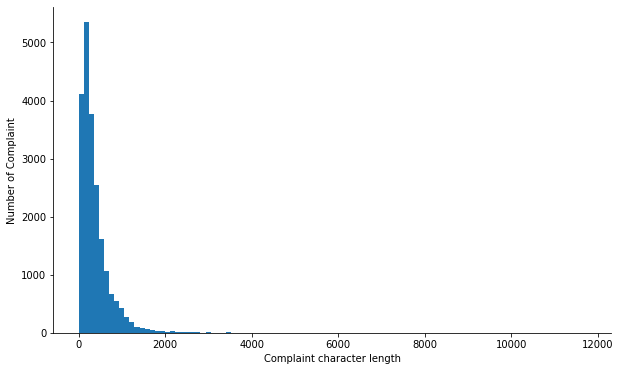

In [24]:
# Write your code here to visualise the data according to the 'Complaint' character length
plt.figure(figsize=(10,6))
doc_lens = [len(d) for d in df_clean.complaint_POS_removed]
plt.hist(doc_lens, bins = 100)
plt.ylabel('Number of Complaint')
plt.xlabel('Complaint character length')
sns.despine();

#### Find the top 40 words by frequency among all the articles after processing the text.

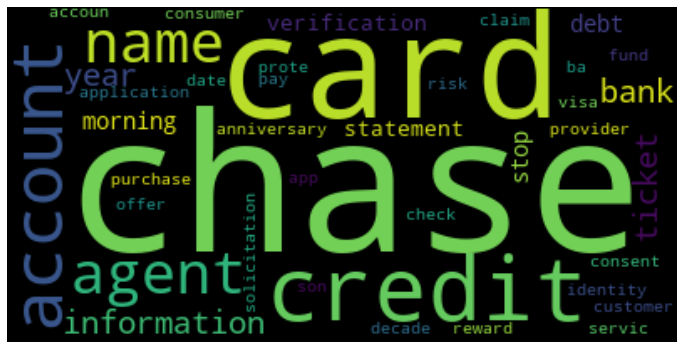

In [25]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
from wordcloud import WordCloud,STOPWORDS
wordcloud = WordCloud(max_words=40, random_state=1, stopwords=set(STOPWORDS))
wordcloud.generate(str(df_clean['complaint_POS_removed']))
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [26]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

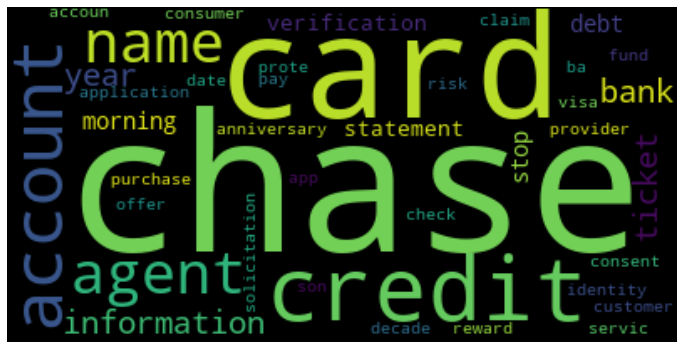

In [27]:
wordcloud = WordCloud(max_words=40, random_state=1, stopwords=set(STOPWORDS))
wordcloud.generate(str(df_clean['Complaint_clean']))
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [28]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
def top_grams(grams):
    c_vec = CountVectorizer(stop_words=stopwords.words('english'), ngram_range=(grams,grams))
    grams = c_vec.fit_transform(df_clean['complaints'])
    count_values = grams.toarray().sum(axis=0)
    vocab = c_vec.vocabulary_
    df_ngram = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)
            ).rename(columns={0: 'frequency', 1:'unigram'})
    return df_ngram
    

In [29]:
df_unigram = top_grams(1)
df_unigram.head(30)

,frequency,unigram
0,80853,chase
1,42751,account
2,32812,credit
3,26946,card
4,26765,bank
5,20364,would
6,16383,told
7,14127,payment
8,13477,called
9,12877,received


In [30]:
#Print the top 10 words in the unigram frequency
df_unigram = top_grams(1)
df_unigram.head(10)

,frequency,unigram
0,80853,chase
1,42751,account
2,32812,credit
3,26946,card
4,26765,bank
5,20364,would
6,16383,told
7,14127,payment
8,13477,called
9,12877,received


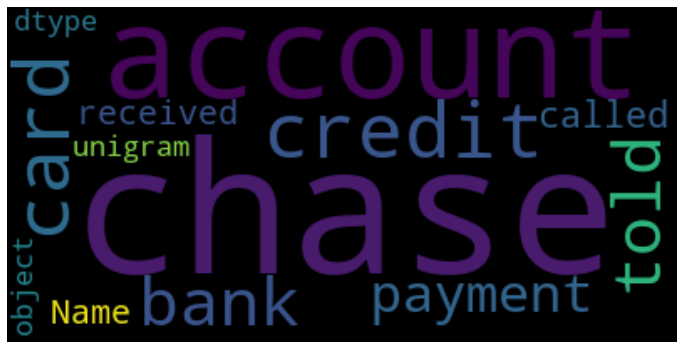

In [31]:
wordcloud.generate(str(df_unigram['unigram'].head(10)))
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [32]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
def top_grams(grams):
    c_vec = CountVectorizer(stop_words=stopwords.words('english'), ngram_range=(grams,grams))
    grams = c_vec.fit_transform(df_clean['complaints'])
    count_values = grams.toarray().sum(axis=0)
    vocab = c_vec.vocabulary_
    df_ngram = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)
            ).rename(columns={0: 'frequency', 1:'bigram'})
    return df_ngram
    

In [33]:
#Print the top 10 words in the bigram frequency
#df_bigram = top_grams(2)
#df_bigram.head(10)

In [34]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
def top_grams(grams):
    c_vec = CountVectorizer(stop_words=stopwords.words('english'), ngram_range=(grams,grams))
    grams = c_vec.fit_transform(df_clean['complaints'])
    count_values = grams.toarray().sum(axis=0)
    vocab = c_vec.vocabulary_
    df_ngram = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)
            ).rename(columns={0: 'frequency', 1:'trigram'})
    return df_ngram

In [35]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
#df_trigram = top_grams(3)
#df_trigram.head(10)

In [36]:
#Print the top 10 words in the trigram frequency


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [37]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [38]:
#All masked texts has been removed
df_clean

,complaints,lemmatized,complaint_POS_removed,Complaint_clean
1,good morning my name is and i appreciate it if...,good morning my name is and i appreciate it if...,morning name stop debt verification statement ...,morning name stop debt verification statement ...
2,i upgraded my card in and was told by the agen...,i upgraded my card in and wa told by the agent...,card agent anniversary date agent information ...,card agent anniversary date agent information ...
10,chase card was reported on however fraudulent ...,chase card wa reported on however fraudulent a...,chase card application identity consent servic...,chase card application identity consent servic...
11,on while trying to book a ticket i came across...,on while trying to book a ticket i came across...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...
14,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son check chase account fund chase bank accoun...,son check chase account fund chase bank accoun...
...,...,...,...,...
78303,after being a chase card customer for well ove...,after being a chase card customer for well ove...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...
78309,on wednesday i called chas my visa credit card...,on wednesday i called chas my visa credit card...,visa credit card provider claim purchase prote...,visa credit card provider claim purchase prote...
78310,i am not familiar with pay and did not underst...,i am not familiar with pay and did not underst...,pay risk consumer chase bank app chase year ba...,pay risk consumer chase bank app chase year ba...
78311,i have had flawless credit for yrs i ve had ch...,i have had flawless credit for yr i ve had cha...,credit yr chase credit card chase freedom prob...,credit yr chase credit card chase freedom prob...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [39]:
#Write your code here to initialise the TfidfVectorizer 

tfidf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [40]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm = tfidf.fit_transform(df_clean['complaints'])

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [41]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [42]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5

#keep the random_state =40
nmf_model = NMF(random_state=40, n_components=num_topics)

In [43]:
nmf_model.fit(dtm)
len(tfidf.get_feature_names())

14985

In [44]:
#Print the Top15 words for each of the topics
words = np.array(tfidf.get_feature_names())
topic_words_df = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)

for i in range(num_topics):
    ix = nmf_model.components_[i].argsort()[::-1][:15]
    topic_words_df.iloc[i] = words[ix]

topic_words_df

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,card,chase,charges,charge,dispute,fraud,called,received,did,told,merchant,claim,transaction,said,refund
Topic 2,credit,card,report,inquiry,chase,inquiries,hard,cards,reporting,score,accounts,account,closed,debt,removed
Topic 3,loan,mortgage,chase,home,modification,property,foreclosure,payments,house,bank,years,sale,morgan,rate,jp
Topic 4,account,bank,check,chase,money,funds,checking,closed,deposit,branch,told,accounts,deposited,said,business
Topic 5,payment,late,payments,balance,paid,pay,month,fees,fee,statement,auto,account,chase,charged,monthly


In [45]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4

topic_results = nmf_model.transform(dtm)
topic_results.argmax(axis=1)

array([2, 0, 1, ..., 0, 4, 4])

In [46]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = topic_results.argmax(axis=1)

In [47]:
df_clean.head()

,complaints,lemmatized,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is and i appreciate it if...,good morning my name is and i appreciate it if...,morning name stop debt verification statement ...,morning name stop debt verification statement ...,2
2,i upgraded my card in and was told by the agen...,i upgraded my card in and wa told by the agent...,card agent anniversary date agent information ...,card agent anniversary date agent information ...,0
10,chase card was reported on however fraudulent ...,chase card wa reported on however fraudulent a...,chase card application identity consent servic...,chase card application identity consent servic...,1
11,on while trying to book a ticket i came across...,on while trying to book a ticket i came across...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...,1
14,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son check chase account fund chase bank accoun...,son check chase account fund chase bank accoun...,3


In [48]:
#Print the first 5 Complaint for each of the Topics
df_group=df_clean.groupby('Topic').head(5)
df_group.sort_values('Topic')

,complaints,lemmatized,complaint_POS_removed,Complaint_clean,Topic
2,i upgraded my card in and was told by the agen...,i upgraded my card in and wa told by the agent...,card agent anniversary date agent information ...,card agent anniversary date agent information ...,0
21,on i made a payment to an online retailer usin...,on i made a payment to an online retailer usin...,payment retailer chase pay chase website scam ...,payment retailer chase pay chase website scam ...,0
43,chase sent me an email today with the innocuou...,chase sent me an email today with the innocuou...,chase email today title information change cha...,chase email today title information change cha...,0
40,a sofa love seat table and chairs and was nev...,a sofa love seat table and chair and wa never ...,sofa love seat table chair debit card bank cla...,sofa love seat table chair debit card bank cla...,0
32,my chase amazon card was declined for a cateri...,my chase amazon card wa declined for a caterin...,chase amazon card catering order brother funer...,chase amazon card catering order brother funer...,0
10,chase card was reported on however fraudulent ...,chase card wa reported on however fraudulent a...,chase card application identity consent servic...,chase card application identity consent servic...,1
11,on while trying to book a ticket i came across...,on while trying to book a ticket i came across...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...,1
15,can you please remove inquiry,can you please remove inquiry,inquiry,inquiry,1
23,i have a chase credit card which is incorrectl...,i have a chase credit card which is incorrectl...,chase credit card credit report company issue,chase credit card credit report company issue,1
26,i have reached out to several times in attempt...,i have reached out to several time in attempt ...,time attempt inquiry creditor inquiry report a...,time attempt inquiry creditor inquiry report a...,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [49]:
#Create the dictionary of Topic names and Topics

# Create the dictionary of Topic names and Topics
Topic_names = {0:'Bank Account Services', 1:'Others Services', 2:'Mortgage/Loan', 3:'Credit card or Prepaid card', 4:'Theft/Dispute Reporting'}

# Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [50]:
df_clean2=df_clean
df_clean2.head(10)

,complaints,lemmatized,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is and i appreciate it if...,good morning my name is and i appreciate it if...,morning name stop debt verification statement ...,morning name stop debt verification statement ...,Mortgage/Loan
2,i upgraded my card in and was told by the agen...,i upgraded my card in and wa told by the agent...,card agent anniversary date agent information ...,card agent anniversary date agent information ...,Bank Account Services
10,chase card was reported on however fraudulent ...,chase card wa reported on however fraudulent a...,chase card application identity consent servic...,chase card application identity consent servic...,Others Services
11,on while trying to book a ticket i came across...,on while trying to book a ticket i came across...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...,Others Services
14,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son check chase account fund chase bank accoun...,son check chase account fund chase bank accoun...,Credit card or Prepaid card
15,can you please remove inquiry,can you please remove inquiry,inquiry,inquiry,Others Services
17,with out notice j p morgan chase restricted my...,with out notice j p morgan chase restricted my...,notice chase account debit card branch custome...,notice chase account debit card branch custome...,Credit card or Prepaid card
20,during the summer months i eperience a decline...,during the summer month i eperience a decline ...,summer month decline income employment month p...,summer month decline income employment month p...,Theft/Dispute Reporting
21,on i made a payment to an online retailer usin...,on i made a payment to an online retailer usin...,payment retailer chase pay chase website scam ...,payment retailer chase pay chase website scam ...,Bank Account Services
23,i have a chase credit card which is incorrectl...,i have a chase credit card which is incorrectl...,chase credit card credit report company issue,chase credit card credit report company issue,Others Services


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [51]:
#Create the dictionary again of Topic names and Topics

Topic_names = {'Bank Account Services':0, 'Others Services':1, 'Mortgage/Loan':2, 'Credit card or Prepaid card':3, 'Theft/Dispute Reporting':4}
# Replace Topics with Topic Names
df_clean2['Topic'] = df_clean2['Topic'].map(Topic_names)

In [52]:
df_clean2

,complaints,lemmatized,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is and i appreciate it if...,good morning my name is and i appreciate it if...,morning name stop debt verification statement ...,morning name stop debt verification statement ...,2
2,i upgraded my card in and was told by the agen...,i upgraded my card in and wa told by the agent...,card agent anniversary date agent information ...,card agent anniversary date agent information ...,0
10,chase card was reported on however fraudulent ...,chase card wa reported on however fraudulent a...,chase card application identity consent servic...,chase card application identity consent servic...,1
11,on while trying to book a ticket i came across...,on while trying to book a ticket i came across...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...,1
14,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son check chase account fund chase bank accoun...,son check chase account fund chase bank accoun...,3
...,...,...,...,...,...
78303,after being a chase card customer for well ove...,after being a chase card customer for well ove...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...,1
78309,on wednesday i called chas my visa credit card...,on wednesday i called chas my visa credit card...,visa credit card provider claim purchase prote...,visa credit card provider claim purchase prote...,0
78310,i am not familiar with pay and did not underst...,i am not familiar with pay and did not underst...,pay risk consumer chase bank app chase year ba...,pay risk consumer chase bank app chase year ba...,0
78311,i have had flawless credit for yrs i ve had ch...,i have had flawless credit for yr i ve had cha...,credit yr chase credit card chase freedom prob...,credit yr chase credit card chase freedom prob...,4


In [53]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=df_clean2.drop(['lemmatized', 'complaint_POS_removed', 'Complaint_clean'], axis=1)

In [54]:
training_data

,complaints,Topic
1,good morning my name is and i appreciate it if...,2
2,i upgraded my card in and was told by the agen...,0
10,chase card was reported on however fraudulent ...,1
11,on while trying to book a ticket i came across...,1
14,my grand son give me check for i deposit it in...,3
...,...,...
78303,after being a chase card customer for well ove...,1
78309,on wednesday i called chas my visa credit card...,0
78310,i am not familiar with pay and did not underst...,0
78311,i have had flawless credit for yrs i ve had ch...,4


####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [55]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import classification_report,accuracy_score

In [56]:
# Write your code to get the Vector count
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(training_data.complaints)

# Write your code here to transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [57]:
# Write your code here to build any 3 models and evaluate them using the required metrics

x_train, x_test, y_train, y_test = train_test_split(X_train_tfidf, training_data.Topic, test_size=0.25, random_state=42)


In [58]:
x_train

<15804x27795 sparse matrix of type '<class 'numpy.float64'>'
	with 1681090 stored elements in Compressed Sparse Row format>

### **1.Logistic Regression**

In [59]:
# Logistic Regression
lr = LogisticRegression(class_weight='balanced',max_iter=300,C=4)
lr.fit(x_train,y_train)

#Predict class
y_test_pred_LR = lr.predict(x_test)

accuracy_dict = {}

print(classification_report(y_true=y_test, y_pred=y_test_pred_LR))
print('Accuracy: ',accuracy_score(y_test,y_test_pred_LR))
accuracy_dict.update({'Logistic Regression':accuracy_score(y_test,y_test_pred_LR)})

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1190
           1       0.96      0.95      0.96      1101
           2       0.97      0.96      0.96       924
           3       0.97      0.96      0.96      1400
           4       0.93      0.95      0.94       653

    accuracy                           0.96      5268
   macro avg       0.95      0.95      0.95      5268
weighted avg       0.96      0.96      0.96      5268

Accuracy:  0.9552012148823082


## **2. Decision Trees**

In [60]:
# Decision tree classifier
dt = DecisionTreeClassifier(max_depth=3,min_samples_leaf=3,max_leaf_nodes=5).fit(x_train, y_train)
predicted = dt.predict(x_test)

print(classification_report(y_pred=predicted, y_true=y_test))

              precision    recall  f1-score   support

           0       0.44      0.66      0.53      1190
           1       0.69      0.81      0.75      1101
           2       0.90      0.52      0.66       924
           3       0.68      0.73      0.70      1400
           4       0.76      0.20      0.32       653

    accuracy                           0.63      5268
   macro avg       0.70      0.58      0.59      5268
weighted avg       0.68      0.63      0.62      5268



## **3.Random Forest Classifier**

In [61]:
rfc = RandomForestClassifier(max_depth=10,max_leaf_nodes=5,min_samples_leaf=2,n_estimators=5)
rfc.fit(x_train, y_train)
predicted = rfc.predict(x_test)

print(classification_report(y_pred=predicted, y_true=y_test))

              precision    recall  f1-score   support

           0       0.55      0.37      0.44      1190
           1       0.48      0.25      0.33      1101
           2       0.60      0.36      0.45       924
           3       0.38      0.90      0.53      1400
           4       0.00      0.00      0.00       653

    accuracy                           0.44      5268
   macro avg       0.40      0.38      0.35      5268
weighted avg       0.43      0.44      0.39      5268



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



### **4. Gaussian Naive Bayes**

In [62]:
nb = GaussianNB().fit(x_train.toarray(), y_train)
predicted = nb.predict(x_test.toarray())

print(classification_report(y_pred=predicted, y_true=y_test))

              precision    recall  f1-score   support

           0       0.50      0.36      0.42      1190
           1       0.34      0.28      0.31      1101
           2       0.53      0.50      0.51       924
           3       0.46      0.30      0.36      1400
           4       0.19      0.50      0.27       653

    accuracy                           0.37      5268
   macro avg       0.40      0.39      0.38      5268
weighted avg       0.42      0.37      0.38      5268



### **Logistic Regression performs the best among all the models**

### **Conclusion**
We have identified 5 clusters based on the product/services:


1.   Bank Account Services
2.   Other services
3.   Mortage/Loans
4.   Credit card or Prepaid Card
5.   THeft/Dispute Reporting

We have also tried 4 different models.
Among the models **Logistics regression** performs the best as its accuracy is 96%.





### **Infering the best Model**

In [63]:
df_complaints = pd.DataFrame({'complaints': ["What is the process I need to follow to know my credit score?",
                                             "I need to know the number of bank branches and their locations in or around New York",
                                             "Last Week, I received a fraudulent email regarding winning a lottery for my services.",
                                  "I can not get from chase who services my mortgage, who owns it and who has original loan docs", 
                                  "The bill amount of my credit card was debited twice. Please look into the matter and resolve at the earliest.",
                                  "I want to open a salary account at your downtown branch. Please provide me with the required process to follow.",
                                  ]})
df_complaints

,complaints
0,What is the process I need to follow to know m...
1,I need to know the number of bank branches and...
2,"Last Week, I received a fraudulent email regar..."
3,I can not get from chase who services my mortg...
4,The bill amount of my credit card was debited ...
5,I want to open a salary account at your downto...


In [64]:
def predict_lr(text):
    Topic_names = {0:'Bank Account Services', 1:'Others Services', 2:'Mortgage/Loan', 3:'Credit card or Prepaid card', 4:'Theft/Dispute Reporting'}
    x_new_counts = count_vect.transform(text)
    x_new_tfidf = tfidf_transformer.transform(x_new_counts)
    predicted = lr.predict(x_new_tfidf)
    return Topic_names[predicted[0]]

In [65]:
df_complaints['tag'] = df_complaints['complaints'].apply(lambda x: predict_lr([x]))
df_complaints

,complaints,tag
0,What is the process I need to follow to know m...,Others Services
1,I need to know the number of bank branches and...,Credit card or Prepaid card
2,"Last Week, I received a fraudulent email regar...",Bank Account Services
3,I can not get from chase who services my mortg...,Mortgage/Loan
4,The bill amount of my credit card was debited ...,Others Services
5,I want to open a salary account at your downto...,Credit card or Prepaid card


## **All the topics have been identified by providing sample inputs to the prediction algorithm.**